# PlanGrid Lost Opportunities Analysis  
Ankur Vishwakarma  
November 25, 2020

In [1]:
# import everything 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snowflake.connector as snow

In [2]:
# write function to get data from snowflake

def query_snowflake(sql_query):
    '''Runs the supplied query and returns a Pandas dataframe.'''
    
    ctx = snow.connect( 
        account   = os.getenv('snowflake_account'),
        user      = os.getenv('snowflake_username'),
        password  = os.getenv('snowflake_password'),
        warehouse = os.getenv('snowflake_warehouse'),
        role      = os.getenv('snowflake_role')
    )

    cs = ctx.cursor()

    try:
        cs.execute(sql_query)
        data = pd.DataFrame(cs.fetchall())
        data.columns = [x[0] for x in cs.description]
    finally:
        cs.close()

    ctx.close()
    
    return data

In [17]:
# sql query

sql_query = """
    with
    post_merger_opps as (
        select o.*
        from pg_prod_db.salesforce.opportunity o
        where o.created_date >= '2020-02-01'
        and (PLAN_GRID_REA_C is not null or (type = 'Renewal' and renewal_type_c = 'PlanGrid'))
        or (name ilike '%plangrid%' or name ilike '% pg%' or name ilike '%pg %')
        and stage_name in ('Closed Lost', 'Closed Won', 'Booked')
    ),
    
    pre_merger_opps as(
        select o.*      
        from pg_prod_db.salesforce.opportunity o
        where o.created_date < '2020-02-01'
        and o.assemble_ext_id_c is null 
        and o.bc_ext_id_c is null 
    ),
    
    unioned as (
        select * from post_merger_opps
        union
        select * from pre_merger_opps
    ),
    
    adsk_quarters as (
        select 
            date, 
            CONCAT(RIGHT(QUARTER_ADSK_TEXT_LONG, 4), '-', LEFT(QUARTER_ADSK_TEXT_LONG, 2)) as QUARTER_ADSK_TEXT_LONG
        from bc_prod_db.analytics.fct_calendar
    ),
    
    add_dates as (
        select 
            u.*,
            d1.QUARTER_ADSK_TEXT_LONG as CREATED_QUARTER,
            d2.QUARTER_ADSK_TEXT_LONG as CLOSE_QUARTER
        from unioned u 
        left join adsk_quarters d1 on u.created_date::date = d1.date
        left join adsk_quarters d2 on u.close_date::date = d2.date
    ),
    
    final as (
        select 
            case 
                /* updated 11/24/20 */
                when o.currency_iso_code = 'AED' then 0.272294
                when o.currency_iso_code = 'AUD' then 0.735767
                when o.currency_iso_code = 'CAD' then 0.769167
                when o.currency_iso_code = 'EUR' then 1.18859
                when o.currency_iso_code = 'GBP' then 1.33535
                when o.currency_iso_code = 'HKD' then 0.129004
                when o.currency_iso_code = 'INR' then 0.0135074
                when o.currency_iso_code = 'JPY' then 0.00956707
                when o.currency_iso_code = 'SGD' then 0.745197
                when o.currency_iso_code = 'USD' then 1.00
                end as currency_conversion,
            case 
                when o.Finance_Confirmed_c is null or o.Finance_Confirmed_c = 0
                then o.reps_calculated_amount_c
                else o.Finance_Confirmed_c
                end as reporting_gross_new_arr,
            reporting_gross_new_arr*currency_conversion as reporting_gross_new_arr_usd,
            reporting_gross_new_arr_usd*(o.probability/100.0) as weighted_rea_usd,
            o.*
        from add_dates o
    ),

    history_data as (
        select 
            opportunity_id,
            created_date as change_date,
            old_value as old_stage_name,
            new_value as new_stage_name,
            row_number() over (partition by opportunity_id order by change_date desc) as rownum
        from pg_prod_db.salesforce.opportunity_field_history
        where field = 'StageName'
        and new_value in ('Booked', 'Closed Lost', 'Closed Won', 'Closed/Lost')
        and old_value not in ('Booked', 'Closed Lost', 'Closed Won', 'Closed/Lost')
    ),

    most_recent_history_data as (
        select *
        from history_data
        where rownum = 1
    ),

    with_history_data as (
        select 
            coalesce(b.change_date, a.close_date) as actual_close_date,
            a.*
        from final a 
        left join most_recent_history_data b on a.id = b.opportunity_id
    )

    select *
    from with_history_data 
    where created_date >= '2018-01-01'
"""

In [18]:
# get data from snowflake

df = query_snowflake(sql_query)

In [19]:
# shape of returned data

df_shape = df.shape
print('{:,} rows and {:,} columns returned.'.format(df_shape[0], df_shape[1]))

122,930 rows and 487 columns returned.


In [20]:
# group opps by type

df['TYPE'].value_counts()

New                    44113
Renewal                38505
Console Add-On         29362
AddOn                   9056
Consulting Services      963
Pilot - Unpaid           608
Token                    253
Educational               11
Partner                    9
New Business               8
BETA                       3
Pilot - Paid               3
Same Source                2
Advisor                    1
Name: TYPE, dtype: int64

In [21]:
# current stage (by percentage) of new opps

df[df['TYPE'] == 'New']['STAGE_NAME'].value_counts(normalize = True)

Closed Lost           0.645796
Booked                0.273842
Closed Won            0.031895
Stage 2               0.028994
Stage 3               0.008660
Stage 1               0.006211
Stage 4               0.002879
Stage 5               0.001541
Received from BD      0.000136
Proposal Delivered    0.000023
Lead                  0.000023
Name: STAGE_NAME, dtype: float64

In [22]:
# preview 

df.head()

,ACTUAL_CLOSE_DATE,CURRENCY_CONVERSION,REPORTING_GROSS_NEW_ARR,REPORTING_GROSS_NEW_ARR_USD,WEIGHTED_REA_USD,ID,IS_DELETED,ACCOUNT_ID,NAME,DESCRIPTION,...,PYPE_AE_C,PYPE_REA_C,DISTRICT_MANAGER_APPROVAL_C,PRIORITY_ACCOUNT_HANDOFF_REASON_C,OTHER_HANDOFF_REASON_C,WORKFLOW_BENCHMARKING_TOOL_C,NEXT_SURVEY_DATE_C,SEND_QUALTRICS_NPSSURVEY_C,CREATED_QUARTER,CLOSE_QUARTER
0,2021-01-09 00:00:00-08:00,1.00000000,0.00,0E-10,0.00,0060W000012InCcQAK,False,0010W00002MsRdIQAV,Pfluger Assocs - 110002005736 - 1/9/2021 - Ren...,Owner in ADSK SFDC: Bill Campbell,...,None,None,False,None,None,None,None,False,2021-Q1,2021-Q4
1,2020-12-01 02:43:09+00:00,1.00000000,1884.00,1884.0000000000,1884.00,0060W0000148hiZQAQ,False,0010W00002KADFQQA5,AC Add-On - CLOBRACO-289845 - 11-30-20,None,...,None,None,False,None,None,None,None,False,2021-Q4,2021-Q4
2,2020-12-29 00:00:00-08:00,1.00000000,0.00,0E-10,0.00,0060W000012Ior0QAC,False,0010W00002Xmx1uQAB,ATR Commercial - 110002910768 - 12/29/2020 - R...,11/30 //BM// LVM and email to eSUB rep Melissa...,...,None,None,False,None,None,None,None,False,2021-Q1,2021-Q4
3,2021-01-01 00:00:00-08:00,1.00000000,0.00,0E-10,0.00,0060W000012IqL0QAK,False,0010W00002Xmy4YQAR,Tata Housing Development Company - 11000199475...,9/14/2020: Sr. CSS BIM 360 Renewals - Marcela ...,...,None,None,False,None,None,None,None,False,2021-Q1,2021-Q4
4,2020-05-01 01:23:20+00:00,1.00000000,15283.35,15283.3500000000,15283.35,0060W000012J3ojQAC,False,001d000001nS2MzAAK,AC Add-On - RUDOLPHA-010083 - 04-30-20,None,...,None,None,None,None,None,None,None,None,2021-Q1,2021-Q1


In [23]:
# group ACV by quarter

acv_by_quarter = pd.DataFrame(df[df['CLOSE_DATE'] <= pd.Timestamp.today()].
                              groupby(by = 'CLOSE_QUARTER')['REPORTING_GROSS_NEW_ARR_USD'].
                              sum())

acv_by_quarter.reset_index(inplace = True)
acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD'] = acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD'].astype(float)
acv_by_quarter['ARR_USD_FORMATTED'] = (acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD']
                                       .apply(lambda x: "${:.1f} M".format((x/1000000))))
acv_by_quarter['YOY_GROWTH'] = ((acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD']/
                                acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD'].shift(periods = 4))-1)
acv_by_quarter['YOY_GROWTH_PERC'] = (acv_by_quarter['YOY_GROWTH']
                                     .apply(lambda x: '{:.2%}'.format(x)))
acv_by_quarter

,CLOSE_QUARTER,REPORTING_GROSS_NEW_ARR_USD,ARR_USD_FORMATTED,YOY_GROWTH,YOY_GROWTH_PERC
0,2016-Q4,0.000000e+00,$0.0 M,NaN,nan%
1,2017-Q4,3.650000e+04,$0.0 M,NaN,nan%
2,2018-Q1,2.276900e+05,$0.2 M,NaN,nan%
3,2018-Q2,1.883030e+05,$0.2 M,NaN,nan%
4,2018-Q3,1.161157e+05,$0.1 M,inf,inf%
5,2018-Q4,2.968701e+06,$3.0 M,80.334261,8033.43%
6,2019-Q1,1.020402e+07,$10.2 M,43.815389,4381.54%
7,2019-Q2,1.384035e+07,$13.8 M,72.500433,7250.04%
8,2019-Q3,1.375484e+07,$13.8 M,117.458047,11745.80%
9,2019-Q4,1.525907e+07,$15.3 M,4.139983,414.00%


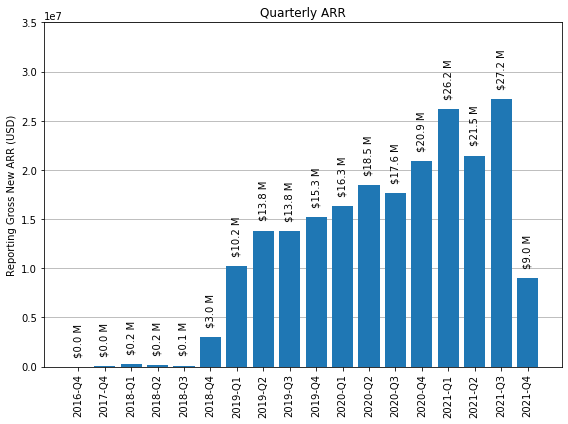

In [74]:
# plot ACV by quarter

ind = np.arange(len(acv_by_quarter['CLOSE_QUARTER']))
y_vals = acv_by_quarter['REPORTING_GROSS_NEW_ARR_USD']

fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(ind, 
                y_vals, 
                width, 
                label='Reporting Gross New ARR (USD)',
                zorder = 3
               )

ax.set_ylabel('Reporting Gross New ARR (USD)')
ax.set_ylim([0, 35000000])
ax.set_title('Quarterly ARR')
ax.set_xticks(ind)
ax.set_xticklabels(acv_by_quarter['CLOSE_QUARTER'], rotation = 90)
ax.grid(axis = 'y', zorder = 0)
# ax.legend()

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, 
                height + 1000000,
                '${:0,.1f} M'.format(height/1000000), 
                ha = ha[xpos], 
                va = 'bottom', 
                rotation = 90
               )


autolabel(rects1, 'center')

plt.tight_layout()
plt.show()

In [25]:
# look at closed lost opps

df[df['STAGE_NAME'] == 'Closed Lost'].head()

,ACTUAL_CLOSE_DATE,CURRENCY_CONVERSION,REPORTING_GROSS_NEW_ARR,REPORTING_GROSS_NEW_ARR_USD,WEIGHTED_REA_USD,ID,IS_DELETED,ACCOUNT_ID,NAME,DESCRIPTION,...,PYPE_AE_C,PYPE_REA_C,DISTRICT_MANAGER_APPROVAL_C,PRIORITY_ACCOUNT_HANDOFF_REASON_C,OTHER_HANDOFF_REASON_C,WORKFLOW_BENCHMARKING_TOOL_C,NEXT_SURVEY_DATE_C,SEND_QUALTRICS_NPSSURVEY_C,CREATED_QUARTER,CLOSE_QUARTER
7,2020-02-24 19:02:52+00:00,1.00000000,708.00,708.0000000000,0.0,0060W000010EfuiQAC,False,0010W00002MvmUuQAJ,WeWork,My contact for WeWork LA has been Erick Morsta...,...,None,None,None,None,None,None,None,None,2020-Q1,2021-Q1
8,2019-05-16 18:22:12+00:00,1.00000000,None,None,NaN,0060W00000yLKznQAG,False,0010W00002KACw0QAH,Dalhousie University - Procurement Department-...,None,...,None,None,None,None,None,None,None,None,2019-Q4,2020-Q2
12,2019-01-04 10:14:57+00:00,1.33535000,4680.00,6249.4380000000,0.0,0060W00000zldCcQAI,False,0010W00002F7wfqQAB,10N/2Y/0PCD,None,...,None,None,None,None,None,None,None,None,2019-Q4,2019-Q4
13,2019-03-29 22:20:30+00:00,1.00000000,397.80,397.8000000000,0.0,0060W000010DvknQAC,False,0010W00002MsSKbQAN,AC Add-On - THEGREAT-346379 - 03-31-19,None,...,None,None,None,None,None,None,None,None,2020-Q1,2020-Q1
14,2019-05-16 15:55:03+00:00,1.00000000,None,None,NaN,0060W00000ywgtqQAA,False,001d0000025J3YqAAK,Construction Longer Inc- new opp,Hospital project in Granby\r\nComparing us wit...,...,None,None,None,None,None,None,None,None,2020-Q1,2020-Q2


In [26]:
print('hello')

hello
